## Отчты по данным BSS
- График по Странам / Кастомерам / TADIG / Sponsor с возможностью задать параметр агрегации
- Кастомер, которые выросли с нуля до указанного суммарного профита
- Оценка маркапа
- Отчет по Not discounted uasge

In [31]:
# Загрузка библиотек и подготовка переменных

import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
from os.path import join
import re
import roamability as rb
from collections import namedtuple

register_matplotlib_converters()

plt.style.use('ggplot')

downloads = 'C:/Users/balob/Downloads'
use_value = 'Revenue' # 'Cost', 'Revenue', 'Profit'

sponsor_object = namedtuple('Sponsor', ['name', 'mccmnc', 'sponsor_id'])

s1_sponsor = sponsor_object('S1', 42501, 1)
s2_sponsor = sponsor_object('S2', 26006, 2)
s4_sponsor = sponsor_object('S4', 45403, 4)
s5_sponsor = sponsor_object('S5', 51503, 5)

sponsors = [s1_sponsor, s2_sponsor, s4_sponsor, s5_sponsor]

# BSS time range report

start_date = '20191001' # Including
end_date = '20191231' # Including
current_date = dt.datetime.now().strftime("%y%m%d")

output_bss_usage_file = f'bss_usage_{start_date}_{end_date}_{current_date}.csv'

In [32]:
# Получение данных из BSS

sql_srt="""
SELECT * FROM
(
SELECT
Day,SponsorPrefix,VisitedCountryId,VisitedNetworkId,Customer,Cost,Revenue
,'DATA' AS UsageType
FROM aggreg.GPRS_AGR
WHERE `Day` BETWEEN {start_date} AND {end_date}
UNION ALL
SELECT
Day,SponsorPrefix,VisitedCountryId,VisitedNetworkId,Customer,Cost,Revenue
,CASE WHEN Sms = 0 THEN 'MOC' WHEN Sms = 1 THEN 'MOSMS' END AS UsageType
FROM aggreg.MOC_AGR
WHERE `Day` BETWEEN {start_date} AND {end_date}
UNION ALL
SELECT
Day,SponsorPrefix,VisitedCountryId,VisitedNetworkId,Customer,Cost,Revenue
,CASE WHEN Sms = 0 THEN 'MTC' WHEN Sms = 1 THEN 'MTSMS' END AS UsageType
FROM aggreg.MTC_AGR
WHERE `Day` BETWEEN {start_date} AND {end_date}
) t
""".format(start_date=start_date, end_date=end_date)

with rb.MySqlConnect('172.18.11.40', 'BSS', 'noc', 'WcQUzkXiXwoxnFfGnRxb') as cnxn:
    df_bss_source = pd.read_sql_query(sql_srt, cnxn)
# df_bss_source.to_csv(join(downloads, output_bss_usage_file), index=False)
df_bss_source.head(3)

,Day,SponsorPrefix,VisitedCountryId,VisitedNetworkId,Customer,Cost,Revenue,UsageType
0,20191001,26006,11,30,172722,0.015770,0.034444,DATA
1,20191001,26006,14,50,172854,0.000561,0.001247,DATA
2,20191001,26006,14,52,172722,7.383140,16.130500,DATA


In [53]:
# Опционально для загрузки из сохраненного ранее файла

# df_bss_source = pd.read_csv(join(downloads, 'bss_usage_20190101_20191130_191220.csv'))
# df_bss_source.head(3)

In [12]:
# Загрузка справочников из OCS

# sql_srt='SELECT network_id AS VisitedNetworkId, MAX(tadig_code) AS Tadig FROM RDB_TADIG_CODES GROUP BY network_id;'

sql_srt="""SELECT t.network_id AS VisitedNetworkId, MAX(c.country_name) AS Country, MAX(t.tadig_code) AS Tadig
FROM RDB_TADIG_CODES t
LEFT JOIN RDB_NETWORKS n ON t.network_id = n.network_id
LEFT JOIN RDB_COUNTRIES c ON n.country_id = c.country_id
GROUP BY t.network_id;"""

with rb.MssqlConnect('172.18.11.82', '10028', 'BSS', 'iKQVm40AZAmyRaw72LeY') as cnxn:
    df_tadig = pd.read_sql_query(sql_srt, cnxn, coerce_float=False)
display(df_tadig.head(3))

sql_srt='SELECT reseller_id AS Customer, reseller_name AS CustomerName FROM RESELLERS;'
with rb.MssqlConnect('172.18.11.82', '10028', 'BSS', 'iKQVm40AZAmyRaw72LeY') as cnxn:
    df_customer = pd.read_sql_query(sql_srt, cnxn, coerce_float=False)
    
df_customer.replace({'STI - Telinta':'STI'}, inplace=True)

display(df_customer.head(3))

,VisitedNetworkId,Country,Tadig
0,4,Afghanistan,AFGAW
1,5,Afghanistan,AFGAR
2,6,Afghanistan,AFGEA


,Customer,CustomerName
0,172711,Mondicon
1,172716,Cloud 9 TAP
2,172717,KnowRoaming IMSI-RANGE TAP


In [13]:
# Подготовка данных и объединение со справочниками

df_bss_processed = df_bss_source.copy()

# Подготовка колонки Profit
df_bss_processed['Profit'] = df_bss_processed['Revenue'] - df_bss_processed['Cost']

# Замена префикса Спонсора на символьное обозначение? S1, S2...
sponsor_dict = dict((sponsor.mccmnc, sponsor.name) for sponsor in sponsors)
df_bss_processed.SponsorPrefix.replace(sponsor_dict, inplace=True)

# Подготовка широкого DF с заданием используемого значения (Cost, Revenue, Profit)
df_bss_processed = df_bss_processed.pivot_table(values=use_value,
                                                index=['Day','SponsorPrefix','VisitedCountryId','VisitedNetworkId','Customer'],
                                                columns='UsageType', aggfunc=np.sum).reset_index()

# Обработка значения даты с добавлением дополнительных полей даты
df_bss_processed.Day = pd.to_datetime(df_bss_processed.Day, format='%Y%m%d')
# df_bss_processed['Week'] = df_bss_processed.Day.dt.strftime('%Y-%W')
df_bss_processed['Week'] = df_bss_processed.Day.dt.ceil('7D')
df_bss_processed['Month'] = df_bss_processed.Day.dt.strftime('%Y-%m')

# Объединение с Customer и TADIG
df_bss_processed = pd.merge(df_bss_processed, df_customer, how='left', on='Customer')
df_bss_processed = pd.merge(df_bss_processed, df_tadig, how='left', on='VisitedNetworkId')

# Добавление поля TOTAL и выборка используемых в дальнейшем полей
df_bss_processed['TOTAL'] = df_bss_processed[['MOC','MTC','MOSMS','MTSMS','DATA']].sum(axis=1)
df_bss_processed = df_bss_processed[
    ['Day', 'Week','Month','SponsorPrefix','CustomerName','Country','Tadig','MOC','MTC','MOSMS','MTSMS','DATA', 'TOTAL']].fillna(0)

df_bss_processed.head(3)

,Day,Week,Month,SponsorPrefix,CustomerName,Country,Tadig,MOC,MTC,MOSMS,MTSMS,DATA,TOTAL
0,2020-01-01,2020-01-02,2020-01,S1,Cloud 9 TAP,Albania,ALBVF,0.0,0.0,0.0,0.0,0.196973,0.196973
1,2020-01-01,2020-01-02,2020-01,S1,Naka TAP,Albania,ALBVF,0.0,0.0,0.0,0.0,2.023370,2.023370
2,2020-01-01,2020-01-02,2020-01,S1,Tottolli-Tech-Mobil,Albania,ALBVF,0.0,0.0,0.0,0.0,0.000027,0.000027


In [16]:
df_bss_processed.loc[df_bss_processed.CustomerName == 'Dialoq - Genesisclub RT',
                     ['Month','TOTAL']].groupby('Month').sum().round(2)

,TOTAL
Month,
2020-01,10661.53


#### График по Странам / Кастомерам / TADIG / Sponsor с возможностью задать параметр агрегации

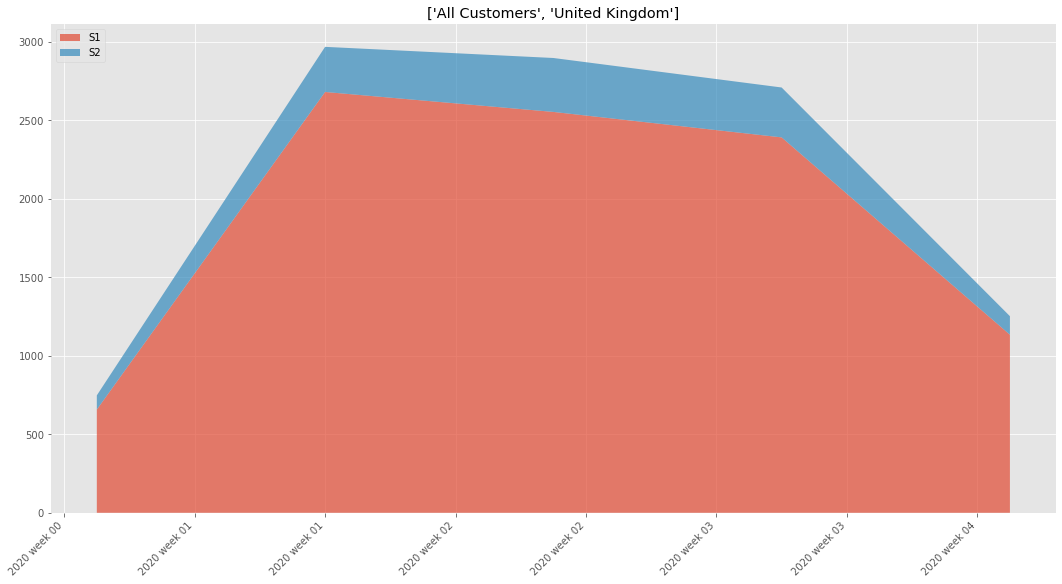

In [9]:
threshold = 100 # Ниже данного порога (USD) значение будет попадать в Other
aggregation_type = 'SponsorPrefix' # CustomerName, Country, Tadig, SponsorPrefix

customer = '' # Define the Customer with regular expression or leave ''
country = 'United Kingdom' # Define the Country with regular expression or leave ''


df_temp = df_bss_processed[
    (df_bss_processed.CustomerName.str.contains(customer, na=False, regex=True, flags=re.I)) &
    (df_bss_processed.Country.str.contains(country, na=False, regex=True, flags=re.I))
].copy()

if customer:
    customer = [value for value in set(df_temp.CustomerName.to_list())]
else:
    customer = ['All Customers']
    
if country:
    country = [value for value in set(df_temp.Country.to_list())]
else:
    country = ['All Countries']
    
plot_name = customer + country
    
s1 = df_temp.groupby(['Week', aggregation_type], as_index=False)['TOTAL'].sum()\
.groupby([aggregation_type])['TOTAL'].max()

list_other = s1[s1.values <= threshold].index.tolist()

df_temp.loc[df_bss_processed[aggregation_type].isin(list_other), [aggregation_type]] = 'Others'

df_temp = df_temp.groupby(['Week', aggregation_type], as_index=False)['TOTAL'].sum()

df_temp = df_temp.pivot_table(values='TOTAL',index=['Week']
                   ,columns=aggregation_type, aggfunc=np.sum).reset_index().sort_values(by='Week')

df_temp.fillna(0, inplace=True)

fig = plt.figure(figsize=(18,9))
ax = fig.add_subplot(1,1,1)
ax.stackplot(df_temp['Week'].values, df_temp.drop('Week', axis=1).T, labels=df_temp.columns[1:], alpha=0.70)
ax.legend(loc='upper left')
plt.xticks(rotation=45, ha="right")

# Удалить рамку графика
for spine in plt.gca().spines.values():
    spine.set_visible(False)

ax.set_title(plot_name) #Задать название графика

date_format = mdates.DateFormatter('%Y week %U')
ax.xaxis.set_major_formatter(date_format)
    
plt.show()

#### Кастомер, которые выросли с нуля до указанного суммарного профита

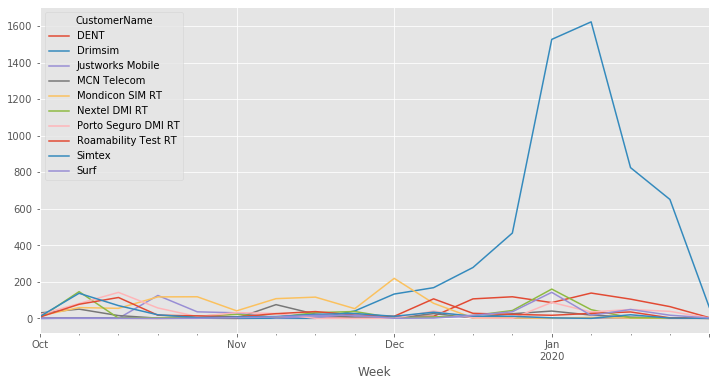

In [13]:
# Summary value
sum_value = 100

# Не учитывать:
exclude_customers = ['Telzar 019 DMI RT', 'TinkLabs  RT']

df_temp = df_bss_processed.groupby(['Week','CustomerName'],as_index=False)['TOTAL'].sum()\
.groupby('CustomerName')['TOTAL'].agg([('ProfitMin', np.min), ('ProfitSum', np.sum)]).reset_index()

df_temp = df_temp[~df_temp.CustomerName.isin(exclude_customers)]

list_breakthrough = df_temp[(df_temp.ProfitMin < 1) & (df_temp.ProfitSum > sum_value)].CustomerName.tolist()

df_bss_processed[df_bss_processed.CustomerName.isin(list_breakthrough)].pivot_table(values='TOTAL',index=['Week']
                   ,columns='CustomerName', aggfunc=np.sum).reset_index().sort_values(by='Week').fillna(0).set_index('Week')\
.plot(figsize=(12,6))
plt.show()

### Оценка маркапа

In [18]:
# Подготовка данных

df_bss = df_bss_source.copy()
sponsor_dict = dict((sponsor.mccmnc, sponsor.name) for sponsor in sponsors)
df_bss.SponsorPrefix.replace(sponsor_dict, inplace=True)
df_bss = df_bss.pivot_table(values=['Cost','Revenue'],index=['Day','SponsorPrefix','VisitedCountryId','VisitedNetworkId','Customer']
                   ,columns='UsageType', aggfunc=np.sum).reset_index()
df_bss.Day = pd.to_datetime(df_bss.Day, format='%Y%m%d')

df_bss.columns = [''.join(col) for col in df_bss.columns]

df_bss = pd.merge(df_bss, df_customer, how='left', on='Customer')
df_bss = pd.merge(df_bss, df_tadig, how='left', on='VisitedNetworkId')
# df_bss_processed['Month'] = df_bss_processed.Day.dt.strftime('%Y-%m')
df_bss = df_bss[
    ['Day','SponsorPrefix','CustomerName','Tadig'
     ,'CostMOC','RevenueMOC','CostMTC','RevenueMTC'
     ,'CostMOSMS','RevenueMOSMS','CostMTSMS','RevenueMTSMS','CostDATA','RevenueDATA']].fillna(0)
df_bss.head(3)

,Day,SponsorPrefix,CustomerName,Tadig,CostMOC,RevenueMOC,CostMTC,RevenueMTC,CostMOSMS,RevenueMOSMS,CostMTSMS,RevenueMTSMS,CostDATA,RevenueDATA
0,2020-01-01,S1,Cloud 9 TAP,ALBVF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.098563,0.196973
1,2020-01-01,S1,Naka TAP,ALBVF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.011510,2.023370
2,2020-01-01,S1,Tottolli-Tech-Mobil,ALBVF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000027


In [15]:
customer_list = np.sort(df_bss.CustomerName.unique())
customer_list

array(['Cellact', 'Clay RT', 'Clementvale', 'Cloud 9 P4 TAP',
       'Cloud 9 TAP', 'DENT', 'Dialoq - Genesisclub RT', 'Drimsim',
       'Freecell', 'Joy_telecom', 'Justworks Mobile',
       'KnowRoaming IMSI-RANGE TAP', 'MCN Telecom', 'Maxcom RT',
       'Mobile NET', 'Mondicon Pepperminds', 'Mondicon SIM RT',
       'Motiv Telecom RUSEC', 'Multi-byte TAP', 'Naka TAP',
       'Netmore DMI RT', 'Nextel DMI RT', 'Porto Seguro DMI RT',
       'RedTea RT', 'Roamability Resellers Test',
       'Roamability Test Orange Sponsor RT', 'Roamability Test RT', 'STI',
       'Simtex', 'Surf', 'TOT RT', 'Taggs', 'TailoredTelecoms',
       'Telzar 019 DMI RT', 'TezTele', 'TinkLabs  RT',
       'Tottolli-Tech-Mobil', 'Tsim', 'V-Tell TAP', 'Vectone TAP',
       'Vision', 'WMB Limited RT', 'We.Stream RT', 'X2One'], dtype=object)

In [30]:
# Выборака данных Кастомеру

markup_rel_tolerance = 0 # 1 - 100% от Chgarge Example: Cost = 10 USD, Charge < 10 USD

customer = 'X2One'
sponsor = ''
start_date = '2020-01-01' # including
end_date = '2020-02-01' # excluding
output_diff_file = f'bss_tariff_diff_{start_date}_{end_date}_{current_date}.xlsx'

df_temp = df_bss.copy()

if customer:
    df_temp = df_temp.loc[df_temp.CustomerName == customer]

if sponsor:
    df_temp = df_temp.loc[df_temp.SponsorPrefix == sponsor]
    
if start_date and end_date:
    df_temp = df_temp[(df_temp.Day >= start_date) & (df_temp.Day < end_date)]

df_temp = df_temp.groupby(
        ['SponsorPrefix','Tadig'], as_index=False).sum()

df_diff = df_temp[
    ~np.isclose(df_temp.CostMOC * 2, df_temp.RevenueMOC, rtol=markup_rel_tolerance, equal_nan=True) |\
    ~np.isclose(df_temp.CostMTC * 2, df_temp.RevenueMTC, rtol=markup_rel_tolerance, equal_nan=True) |\
    ~np.isclose(df_temp.CostMOSMS * 2, df_temp.RevenueMOSMS, rtol=markup_rel_tolerance, equal_nan=True) |\
    ~np.isclose(df_temp.CostMTSMS * 2, df_temp.RevenueMTSMS, rtol=markup_rel_tolerance, equal_nan=True) |\
    ~np.isclose(df_temp.CostDATA * 2, df_temp.RevenueDATA, rtol=markup_rel_tolerance, equal_nan=True)
]

def colorize(s):
    color_list = []
    for tariff_type in [['CostMOC','RevenueMOC'], ['CostMTC','RevenueMTC'],
                        ['CostMOSMS','RevenueMOSMS'], ['CostMTSMS','RevenueMTSMS'], ['CostDATA','RevenueDATA']]:
        if np.isclose(s[tariff_type[0]] * 2, s[tariff_type[1]], rtol=markup_rel_tolerance, equal_nan=True):
            color_list.extend(['', ''])
        elif s[tariff_type[0]] * 2 > s[tariff_type[1]]:
            color_list.extend(['background-color: yellow', 'background-color: red'])
        else:
            color_list.extend(['background-color: yellow', 'background-color: #81EF21'])
    return color_list

df_diff_style = df_diff.style.apply(colorize,
                            subset=['CostMOC','RevenueMOC','CostMTC','RevenueMTC','CostMOSMS','RevenueMOSMS',
                                    'CostMTSMS','RevenueMTSMS','CostDATA','RevenueDATA'], axis=1).hide_index()

display(df_diff_style)
df_diff_style.to_excel(join(downloads, output_diff_file), index=False)

SponsorPrefix,Tadig,CostMOC,RevenueMOC,CostMTC,RevenueMTC,CostMOSMS,RevenueMOSMS,CostMTSMS,RevenueMTSMS,CostDATA,RevenueDATA
S1,ARGTM,0.706048,1.164,0,0,0.047905,0.06,0,0,5.05053,7.85591
S1,BRAV3,10.7552,21.51,0,0,0.215573,0.27,0,0,46.892,72.9361
S1,CANBM,0,0,0,0,0.0419995,0.084,0,0,0.260355,0.520562
S1,CANRW,0.0450004,0.078,0.139984,0.243667,0,0,0,0,3.32657,4.75211
S1,CHEOR,6.0834,12.1668,0,0,0.143963,0.288,0,0,41.2752,82.5401
S1,CHLTM,0,0,0,0,0.119969,0.15,0,0,0,0
S1,FRAF3,0,0,0,0,0.00750236,0.015,0,0,0,0
S1,GBRCN,0.154728,0.309333,0,0,0,0,0,0,0.457162,0.913136
S1,GBRHU,1.83783,3.67566,0,0,0.0433623,0.0868,0,0,5.01205,10.0237
S1,GBRME,15.0151,30.0297,0,0,0.250538,0.502,0,0,3.96607,7.93179


### Отчет по Not discounted uasge

In [8]:
sql_srt="""SELECT t.tadig_code AS Tadig,r.sponsor_id as SponsorPrefix FROM ROAMING_PLAN_RULES r
LEFT JOIN RDB_TADIG_CODES t
ON r.network_id=t.network_id
LEFT JOIN ROAMING_PLANS p
ON r.roaming_plan_id=p.roaming_plan_id
WHERE r.roaming_plan_id IN (267,268,329,343,372)-- (267,268,279,280,281,321,322,323,324)
AND p.deleted IS NULL
--AND ((r.start_date < GETDATE() AND r.end_date is null) OR (r.start_date < GETDATE() AND r.end_date > GETDATE()))
AND ((r.start_date < '2020-02-01 00:00:00') OR (r.start_date < GETDATE() AND r.end_date > GETDATE()))
AND is_discounted = 0;"""

with rb.MssqlConnect('172.18.11.82', '10028', 'BSS', 'iKQVm40AZAmyRaw72LeY') as cnxn:
    df_not_disc = pd.read_sql_query(sql_srt, cnxn, coerce_float=False)
    
df_not_disc.replace(dict([sponsor.sponsor_id, sponsor.name] for sponsor in sponsors), inplace=True)
display(df_not_disc.head(3))

,Tadig,SponsorPrefix
0,ANDMA,S1
1,AGOMV,S1
2,ARGCM,S2


In [28]:
threshold = 100

customer = ''
sponsor = ''
start_date = '2020-01-01' # including
end_date = '2020-02-01' # excluding
output_diff_file = f'bss_not_disc_{start_date}_{end_date}_{current_date}.xlsx'

df_bss_not_disc = pd.merge(df_bss_processed, df_not_disc, how='inner', on=['Tadig','SponsorPrefix'])

if customer:
    df_bss_not_disc = df_bss_not_disc.loc[df_bss_not_disc.CustomerName == customer]

if sponsor:
    df_bss_not_disc = df_bss_not_disc.loc[df_bss_not_disc.SponsorPrefix == sponsor]
    
if start_date and end_date:
    df_bss_not_disc = df_bss_not_disc[(df_bss_not_disc.Day >= start_date) & (df_bss_not_disc.Day < end_date)]

df_bss_not_disc = df_bss_not_disc.groupby(['Month','SponsorPrefix','CustomerName','Country','Tadig'], as_index=False).sum()
df_bss_not_disc = df_bss_not_disc.loc[df_bss_not_disc.TOTAL > threshold]
# df_bss_not_disc.to_excel(join(downloads, output_diff_file), index=False)
df_bss_not_disc

,Month,SponsorPrefix,CustomerName,Country,Tadig,MOC,MTC,MOSMS,MTSMS,DATA,TOTAL
9,2020-01,S1,Naka TAP,Slovakia,SVKO2,7.2594,0.0,83.916,0.0,25028.930,25120.1054
19,2020-01,S2,Dialoq - Genesisclub RT,Malaysia,MYSMT,0.0000,0.0,221.280,0.0,0.000,221.2800
24,2020-01,S2,Dialoq - Genesisclub RT,Thailand,THADT,0.0000,0.0,987.012,0.0,0.000,987.0120
29,2020-01,S2,Naka TAP,Russian Federation,RUSBD,0.0000,0.0,0.000,0.0,14619.000,14619.0000
30,2020-01,S2,Netmore DMI RT,Sweden,SWEEP,0.0000,0.0,0.000,0.0,17711.402,17711.4020
36,2020-01,S2,Tottolli-Tech-Mobil,Russian Federation,RUSBD,0.0000,0.0,0.000,0.0,1273.620,1273.6200
38,2020-01,S2,Vectone TAP,Pakistan,PAKMK,0.0000,0.0,0.000,0.0,2357.864,2357.8640
45,2020-01,S2,WMB Limited RT,Malaysia,MYSMT,0.0000,0.0,829.800,0.0,0.000,829.8000


### Сделать:
- Распределение трафика по типу (data/moc/mtc)

### Developments

In [24]:
df_bss_processed.head()

,Day,Week,Month,SponsorPrefix,CustomerName,Country,Tadig,MOC,MTC,MOSMS,MTSMS,DATA,TOTAL
0,2020-01-01,2020-01-02,2020-01,S1,Cloud 9 TAP,Albania,ALBVF,0.0,0.0,0.000,0.0,0.196973,0.196973
1,2020-01-01,2020-01-02,2020-01,S1,Naka TAP,Albania,ALBVF,0.0,0.0,0.000,0.0,2.023370,2.023370
2,2020-01-01,2020-01-02,2020-01,S1,Tottolli-Tech-Mobil,Albania,ALBVF,0.0,0.0,0.000,0.0,0.000027,0.000027
3,2020-01-01,2020-01-02,2020-01,S1,Naka TAP,Antigua and Barbuda,ATGCW,0.0,0.0,0.048,0.0,0.906234,0.954234
4,2020-01-01,2020-01-02,2020-01,S1,Cloud 9 TAP,Argentina,ARGTM,0.0,0.0,0.000,0.0,0.000000,0.000000


In [25]:
df_bss_processed.loc[df_bss_processed.Tadig=='EGYEM']

,Day,Week,Month,SponsorPrefix,CustomerName,Country,Tadig,MOC,MTC,MOSMS,MTSMS,DATA,TOTAL
7174,2020-01-08,2020-01-09,2020-01,S2,X2One,Egypt,EGYEM,0.0,0.0,4002.88,0.0,0.0,4002.88
8087,2020-01-09,2020-01-09,2020-01,S2,X2One,Egypt,EGYEM,0.0,0.0,2741.70,0.0,0.0,2741.70
11615,2020-01-13,2020-01-16,2020-01,S2,STI,Egypt,EGYEM,0.0,0.0,0.00,0.0,0.0,0.00
13345,2020-01-15,2020-01-16,2020-01,S2,STI,Egypt,EGYEM,0.0,0.0,0.00,0.0,0.0,0.00


In [27]:
df_not_disc.loc[df_not_disc.Tadig=='EGYEM']

,Tadig,SponsorPrefix


In [29]:
4002.88 + 2741.70

6744.58